In [21]:
import time
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [8]:
# Load training embeddings and labels
train_codes = pd.read_csv('train_embbeds.csv')
train_labels = pd.read_csv('train_labels.csv')
train_set = train_codes.iloc[:,0:1024].values
train_set_labels= train_labels.iloc[:,:].values
print(train_set.shape)
print(train_set_labels.shape)

(53999, 1024)
(53999, 1)


In [9]:
# Load validation embeddings and labels
valid_codes = pd.read_csv('valid_embbeds.csv')
valid_labels = pd.read_csv('valid_labels.csv')
valid_set = valid_codes.iloc[:,0:1024].values
valid_set_labels= valid_labels.iloc[:,:].values
print(valid_set.shape)
print(valid_set_labels.shape)

(8999, 1024)
(8999, 1)


In [10]:
# Load test embeddings and labels
test_codes = pd.read_csv('test_embbeds.csv')
test_labels = pd.read_csv('test_labels.csv')
test_set = test_codes.iloc[:,0:1024].values
test_set_labels= test_labels.iloc[:,:].values
print(test_set.shape)
print(test_set_labels.shape)

(17999, 1024)
(17999, 1)


In [11]:
def sliding_windows(dataX,dataY, seq_length):
    print("shape of data: ", dataX.shape)
    print("shape of data labels: ", dataY.shape)
    print("seq_length: ", seq_length)
    
    x = [] #Sliding window of embeddings
    y = [] #Predicted label
    
    for i in range(len(dataX)-seq_length-1):
        _x = dataX[i:(i+seq_length)]
        _y = dataY[i+seq_length]
        x.append(_x)
        y.append(_y)
    
    x_array=np.array(x)
    y_array=np.array(y)
    
    return torch.tensor(x_array), torch.tensor(y_array)

In [12]:
seq_length = 5
x_train, y_train = sliding_windows(train_set, train_set_labels, seq_length)

print("The shape of x_train: ", x_train.size())
print("The shape of y_train: ", y_train.size())

x_train=x_train.float()
y_train=y_train.float()

shape of data:  (53999, 1024)
shape of data labels:  (53999, 1)
seq_length:  5
The shape of x_train:  torch.Size([53993, 5, 1024])
The shape of y_train:  torch.Size([53993, 1])


In [13]:
seq_length = 5
x_test, y_test = sliding_windows(test_set, test_set_labels, seq_length)

print("The shape of x_train: ", x_test.size())
print("The shape of y_train: ", y_test.size())

x_test=x_test.float()
y_test=y_test.float() 

shape of data:  (17999, 1024)
shape of data labels:  (17999, 1)
seq_length:  5
The shape of x_train:  torch.Size([17993, 5, 1024])
The shape of y_train:  torch.Size([17993, 1])


In [14]:
x_valid, y_valid = sliding_windows(valid_set, valid_set_labels, seq_length)

print("The shape of x_valid: ", x_valid.size())
print("The shape of y_valid: ", y_valid.size())

x_valid=x_valid.float()
y_valid=y_valid.float()

shape of data:  (8999, 1024)
shape of data labels:  (8999, 1)
seq_length:  5
The shape of x_valid:  torch.Size([8993, 5, 1024])
The shape of y_valid:  torch.Size([8993, 1])


In [15]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [17]:
batch_size=8192 #Large batch size to preserve sequential data

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = torch.utils.data.TensorDataset(x_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [31]:
learning_rate = 0.00034

input_size = 1024
hidden_size = 512
num_layers = 1

num_classes = 1

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, device)
lstm.to(device)
print("Number of parameters: ", sum(p.numel() for p in lstm.parameters()))

criterion = torch.nn.MSELoss()    # mean-sqaured error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

Number of parameters:  3150337


In [32]:
def training(model, criterion, optimizer, train_loader, test_loader, epochs):
    # start a clock 
    start_time = time.time()
    
    train_losses = np.zeros(epochs)
    #test_losses = np.zeros(epochs)
    valid_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        batch_train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        #batch_test_loss = []
        #for test_inputs, test_targets in test_loader:
            #test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)  # Move test inputs and targets to the GPU
            #test_outputs = model(test_inputs)
            #loss = criterion(test_outputs, test_targets)
            #batch_test_loss.append(loss.item())
            
        batch_valid_loss = []
        for valid_inputs, valid_targets in valid_loader:
            valid_inputs, valid_targets = valid_inputs.to(device), valid_targets.to(device)  # Move test inputs and targets to the GPU
            valid_outputs = model(valid_inputs)
            loss = criterion(valid_outputs, valid_targets)
            batch_valid_loss.append(loss.item())   
            

        train_loss = np.mean(batch_train_loss)
        #test_loss = np.mean(batch_test_loss)
        valid_loss = np.mean(batch_valid_loss)

        train_losses[it] = train_loss
        #test_losses[it] = test_loss
        valid_losses[it] = train_loss

        if (it + 1) % 10 == 0:
            print(f'Epoch {it + 1}/{epochs}, Loss_train: {train_loss:.4f}, Loss_valid: {valid_loss:.4f}')
            
    end_time = time.time()
    train_time = end_time - start_time
    print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
    print('Finished Training')

    return train_losses, valid_losses

In [33]:
epochs=100
train_losses, valid_losses = training(lstm, criterion, optimizer, train_loader, test_loader, epochs)

Epoch 10/100, Loss_train: 0.0126, Loss_valid: 0.0096
Epoch 20/100, Loss_train: 0.0066, Loss_valid: 0.0063
Epoch 30/100, Loss_train: 0.0045, Loss_valid: 0.0050
Epoch 40/100, Loss_train: 0.0033, Loss_valid: 0.0042
Epoch 50/100, Loss_train: 0.0026, Loss_valid: 0.0037
Epoch 60/100, Loss_train: 0.0022, Loss_valid: 0.0034
Epoch 70/100, Loss_train: 0.0020, Loss_valid: 0.0032
Epoch 80/100, Loss_train: 0.0017, Loss_valid: 0.0031
Epoch 90/100, Loss_train: 0.0016, Loss_valid: 0.0030
Epoch 100/100, Loss_train: 0.0014, Loss_valid: 0.0029
Elapsed Training Time:  0:01:43.268900
Finished Training


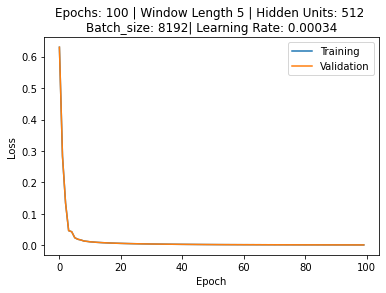

In [35]:
loss_title = "Epochs: " + str(epochs) + " | Window Length " + str(seq_length) +" | Hidden Units: " + str(hidden_size) + " \nBatch_size: " + str(batch_size) + "| Learning Rate: " + str(learning_rate)
plt.title(loss_title)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plt.yscale("log")
plt.plot(train_losses, label= "Training")
plt.plot(valid_losses, label = "Validation")
plt.legend()

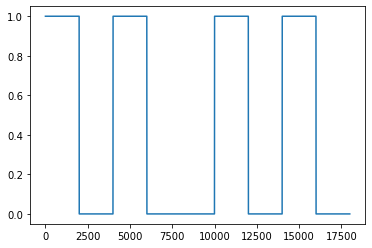

In [36]:
plt.plot(y_test)

In [37]:
lstm.to(device)
lstm.eval()

test_return=np.empty(1)
for test_inputs, test_targets in test_loader:
    test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)  # Move test inputs and targets to the GPU
    test_outputs = lstm(test_inputs)
    test_return=np.append(test_return,test_outputs.to('cpu').detach().numpy())

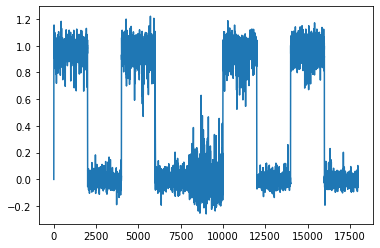

In [38]:
plt.plot(test_return)

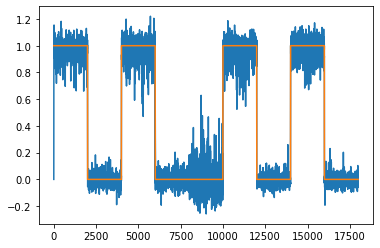

In [39]:
plt.plot(test_return)
plt.plot(y_test)

In [80]:
clamped_test=np.empty(len(test_return)-1)
for i in range(len(test_return)-1):
    if test_return[i]>0.5:
        clamped_test[i]=1
    else:
        clamped_test[i]=0

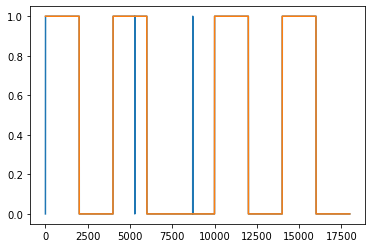

In [81]:
plt.plot(clamped_test)
plt.plot(y_test)

In [82]:
print(clamped_test.shape)

(17993,)


In [83]:
print(y_test.shape)

torch.Size([17993, 1])


In [84]:
y_test_array=y_test.to('cpu').detach().numpy().flatten()

In [85]:
print(y_test_array.shape)

(17993,)


In [88]:
misses = abs(clamped_test - y_test_array).sum(axis=0)

In [89]:
print(misses)

22.0


In [93]:
accuracy=100*(1-(misses/len(y_test_array)))
print('Test Set Accuracy: ',accuracy,'%')

Test Set Accuracy:  99.87773022842217 %
